P => Piecewise Linear Contrast Stretching

GHE => Global Histogram Equalization

CLAHE => Contrast Limited Adaptive Histogram Equalization

# Function label and jpg and png

In [1]:
import os
import glob
import keras
import sklearn
import cv2 as cv2
import numpy as np
import pandas as pd
import PIL as Image
import seaborn as sns
import pathlib as path
import tensorflow as tf
import matplotlib as mpl
from datetime import datetime
import matplotlib.image as img
from keras import backend as k
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import np_utils 
#from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import fashion_mnist
from keras.layers.convolutional import  MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU,Flatten,Activation, GlobalAveragePooling2D, Input
%matplotlib inline

In [2]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    temph = history.history
    temp_loss = temph['loss']
    temp_acc = temph['acc']
    temp_vloss = temph['val_acc']
    temp_vacc = temph['val_acc']

    max_valacc = max(temp_vacc)
    max_index = temp_vacc.index(max_valacc)
    max_index
    # Print the result from the last epoch
    print('Highest validation accuracy in Epoch: %s'%str(max_index+1))
    print('Train accuracy: %s'%temp_acc[max_index])
    print('Validation accuracy: %s'%temp_vacc[max_index])
    print('--------------------------------------------------')
    print('Last train Epoch')
    print('Train accuracy: %s'%history.history['acc'][-1])
    print('Validation accuracy: %s'%history.history['val_acc'][-1])

    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,verbose=True)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    #labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [3]:
from tqdm.notebook import tqdm
import os, fnmatch
from keras import backend as K
from pathlib import Path
# change sub directory in list
def dirToList(dir_path):
  
  #get path create list
  pth = os.listdir(path=dir_path)
  lst_dir = []

  for s in pth:
    temp = str(dir_path + '\\' + s + '\\')
    lst_dir.append(temp)
  
  #remove .csv
  for i in tqdm(range(len(lst_dir))):
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'csv/':
      lst_dir.pop(i-1)
    if lst_dir[i-1][len(lst_dir[i-1])-4:] == 'md/':
      lst_dir.pop(i-1)

  return lst_dir
# map path to name
def mapName(lab_list, lab_dict):
  temp = []
  for i in tqdm(range(len(lab_list))):
    key_label = lab_dict[lab_list[i]]
    temp.append(key_label)
  return temp

#### label

In [4]:
header_list = ["Type", "Description"]
md = pd.read_csv('C:\\Users\\CPE\\Desktop\\senior2023\\fco metdata.csv', names=header_list)
md

,Type,Description
0,ce,Cemento
1,os,Ossifying
2,fi,Fibrous


In [5]:
label_dict = dict(zip(md['Type'], md['Description']))
label_dict

{'ce': 'Cemento', 'os': 'Ossifying', 'fi': 'Fibrous'}

#### Import model

##### model inceptionresnetv2

In [6]:
from tensorflow.keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

In [51]:
def def_model():
    model = InceptionResNetV2(
    include_top=False, 
    input_shape=(224, 224, 3)
      )
    for layer in model.layers:
        layer.trainable = False
    flat1 = Flatten()(model.layers[-1].output)
  #full_conn = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(3, activation='softmax')(flat1)
	# define new model
    model = Model(inputs=model.inputs, outputs=output)
	# compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.save('/content/model/InceptionResNetV21.h5')
    model.summary()
    return model

##### model xception

In [8]:
#load pre trained Xception model
model_xcep1 = keras.applications.Xception(weights='imagenet',include_top=True, input_shape=(299,299,3),classifier_activation=None)

In [9]:
for layer in model_xcep1.layers:
    layer.trainable = False
x = Flatten() (model_xcep1.output)
prediction1 = Dense(3, activation = 'softmax')(x)
xcep1_model = Model(inputs = model_xcep1.input, outputs = prediction1)
xcep1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

##### model efficentnetb2

In [10]:
from keras.applications.efficientnet import EfficientNetB2

In [11]:
model_effi = tf.keras.applications.efficientnet.EfficientNetB2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(260,260,3),
    classifier_activation='softmax'
)
for layer in model_effi.layers:
    layer.trainable = False
x = Flatten() (model_effi.output)
prediction1 = Dense(3, activation = 'softmax')(x)
effi1_model = Model(inputs = model_effi.input, outputs = prediction1)
effi1_model.compile (loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['acc'])

# CLAHE

### Train

In [12]:
sub_dir_train_clahe = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell')
sub_dir_train_clahe

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell\\ce\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell\\fi\\',
 'C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell\\os\\']

In [13]:
sub_dir_train_Path_clahe = Path('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\train_cell')
all_filepaths_train_clahe = list(sub_dir_train_Path_clahe.glob(r'**\\*.png'))
all_filepaths_train_clahe

[WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_002_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_003_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_004_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_005_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_006_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_007_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_008_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_009_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_010_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_011_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/train_cell/ce/ce_012_b.png'),
 WindowsPath('C:

In [14]:
all_path_clahe = []
all_index_clahe = []
for i in tqdm(range(len(sub_dir_train_clahe))):
  tempclahe = fnmatch.filter(os.listdir(sub_dir_train_clahe[i]), "*.png")
  all_path_clahe.append(tempclahe)
all_path_con_clahe =[item for sublist in all_path_clahe for item in sublist]
for i in tqdm(range(len(all_path_con_clahe))):
  index_clahe = all_path_con_clahe[i][:2]
  all_index_clahe.append(index_clahe)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

In [15]:
all_path_map_train_clahe = mapName(all_index_clahe, label_dict)
all_path_map_train_clahe[:10]

  0%|          | 0/446 [00:00<?, ?it/s]

['Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento',
 'Cemento']

In [16]:
all_filepaths_clahe_df = pd.Series(all_filepaths_train_clahe , name = 'filepath').astype(str)
all_path_map_clahe_df = pd.Series(all_path_map_train_clahe, name = 'label')

all_clahe_df = pd.concat([all_filepaths_clahe_df, all_path_map_clahe_df], axis = 1)
all_clahe_df.shape

(446, 2)

In [17]:
all_clahe_df.head()

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
1,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
2,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
3,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
4,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento


### Test

In [18]:
sub_dir_test_clahe = dirToList('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell')
print(sub_dir_test_clahe)

sub_dir_test_Path_clahe = Path('C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell')
all_filepaths_test_clahe = list(sub_dir_test_Path_clahe.glob(r'**\\*.png'))
all_filepaths_test_clahe

  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell\\ce\\', 'C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell\\fi\\', 'C:\\Users\\CPE\\Desktop\\senior2023\\CLAHE\\test_cell\\os\\']


[WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_001_a.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_002_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_003_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_004_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_005_b.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_006_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_007_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_008_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_009_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_010_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_011_c.png'),
 WindowsPath('C:/Users/CPE/Desktop/senior2023/CLAHE/test_cell/ce/ce_012_c.png'),
 WindowsPath('C:/Users/CPE/D

In [19]:
all_path_test_clahe = []
all_index_test_clahe = []
for i in tqdm(range(len(sub_dir_test_clahe))):
  tempclahe2 = fnmatch.filter(os.listdir(sub_dir_test_clahe[i]), "*.png")
  all_path_test_clahe.append(tempclahe2)
all_path_test_con_clahe =[item for sublist in all_path_test_clahe for item in sublist]
for i in tqdm(range(len(all_path_test_con_clahe))):
  index_test_clahe = all_path_test_con_clahe[i][:2]
  all_index_test_clahe.append(index_test_clahe)

all_path_test_map_clahe= mapName(all_index_test_clahe, label_dict)
print(all_path_test_map_clahe[:10])

all_filepaths_test_df_clahe = pd.Series(all_filepaths_test_clahe, name = 'filepath').astype(str)
all_path_test_map_df_clahe = pd.Series(all_path_test_map_clahe, name = 'label')

all_test_df_clahe = pd.concat([all_filepaths_test_df_clahe, all_path_test_map_df_clahe], axis = 1)
all_test_df_clahe.shape

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

['Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento', 'Cemento']


(45, 2)

In [20]:
all_test_df_clahe

,filepath,label
0,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
1,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
2,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
3,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
4,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
5,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
6,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
7,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
8,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento
9,C:\Users\CPE\Desktop\senior2023\CLAHE\test_cel...,Cemento


### Validation

In [21]:
ce_train_data_clahe = all_clahe_df.loc[all_clahe_df['label'] == label_dict['ce']]
fi_train_data_clahe = all_clahe_df.loc[all_clahe_df['label'] == label_dict['fi']]
os_train_data_clahe = all_clahe_df.loc[all_clahe_df['label'] == label_dict['os']]

ce_tr_clahe, ce_va_clahe = train_test_split(ce_train_data_clahe, test_size = .1)
fi_tr_clahe, fe_va_clahe = train_test_split(fi_train_data_clahe, test_size = .45)
os_tr_clahe, os_va_clahe = train_test_split(os_train_data_clahe, test_size = .75)

In [22]:
df_train_clahe = pd.concat([ce_tr_clahe,fi_tr_clahe,os_tr_clahe])
print(df_train_clahe.shape)
df_train_clahe.head()

(192, 2)


,filepath,label
23,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
6,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
1,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
3,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
49,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento


In [23]:
df_val_clahe = pd.concat([ce_va_clahe,fe_va_clahe,os_va_clahe])
print(df_val_clahe.shape)
df_val_clahe.sample(20)

(254, 2)


,filepath,label
419,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
202,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
249,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
48,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Cemento
252,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
193,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
234,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
274,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
351,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying
229,C:\Users\CPE\Desktop\senior2023\CLAHE\train_ce...,Ossifying


### Generator

In [24]:
IMAGE_SIZE = [224,224]
train_generator = ImageDataGenerator(
    rescale=1./255, #rescal Grayscale
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
validation_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)
test_generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip = True
)

X_COL = 'filepath'
Y_COL = 'label'

training_set_clahe = train_generator.flow_from_dataframe(
    dataframe = df_train_clahe,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



validation_set_clahe = validation_generator.flow_from_dataframe(
    dataframe = df_val_clahe,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical')



test_set_clahe = test_generator.flow_from_dataframe(
    dataframe = all_test_df_clahe,
    x_col = X_COL,
    y_col = Y_COL,
    target_size = IMAGE_SIZE,
    batch_size = 4,
    class_mode = 'categorical'
)

Found 192 validated image filenames belonging to 3 classes.
Found 254 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


### Model InceptionResNetV 2

In [52]:
incepv2_3 = def_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_207 (Batch  (None, 111, 111, 32  96         ['conv2d_207[0][0]']             
 Normalization)                 )                                                           

In [53]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_inceptionresnetv2_clahe_model.h5', save_best_only=True, monitor='val_loss')

history_inceptionresnetv2_clahe_model = incepv2_3.fit(
                      training_set_clahe,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_clahe),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
48/48 [==============================] - 137s 2s/step - loss: 7.7261 - acc: 0.4948 - val_loss: 5.0287 - val_acc: 0.5984
Epoch 2/100
48/48 [==============================] - 82s 2s/step - loss: 3.9846 - acc: 0.6875 - val_loss: 3.4283 - val_acc: 0.6654
Epoch 3/100
48/48 [==============================] - 79s 2s/step - loss: 2.4553 - acc: 0.7760 - val_loss: 11.9219 - val_acc: 0.3189
Epoch 4/100
48/48 [==============================] - 82s 2s/step - loss: 3.3157 - acc: 0.7500 - val_loss: 3.1599 - val_acc: 0.7362
Epoch 5/100
48/48 [==============================] - 82s 2s/step - loss: 2.4761 - acc: 0.7865 - val_loss: 1.8853 - val_acc: 0.8228
Epoch 6/100
48/48 [==============================] - 81s 2s/step - loss: 4.0190 - acc: 0.7292 - val_loss: 1.3166 - val_acc: 0.9016
Epoch 7/100
48/48 [==============================] - 78s 2s/step - loss: 5.2767 - acc: 0.7031 - val_loss: 7.8556 - val_acc: 0.5984
Epoch 8/100
48/48 [==============================] - 79s 2s/step - loss: 2.5989 -

Highest validation accuracy in Epoch: 94
Train accuracy: 0.9583333134651184
Validation accuracy: 0.960629940032959
--------------------------------------------------
Last train Epoch
Train accuracy: 0.9479166865348816
Validation accuracy: 0.8031495809555054


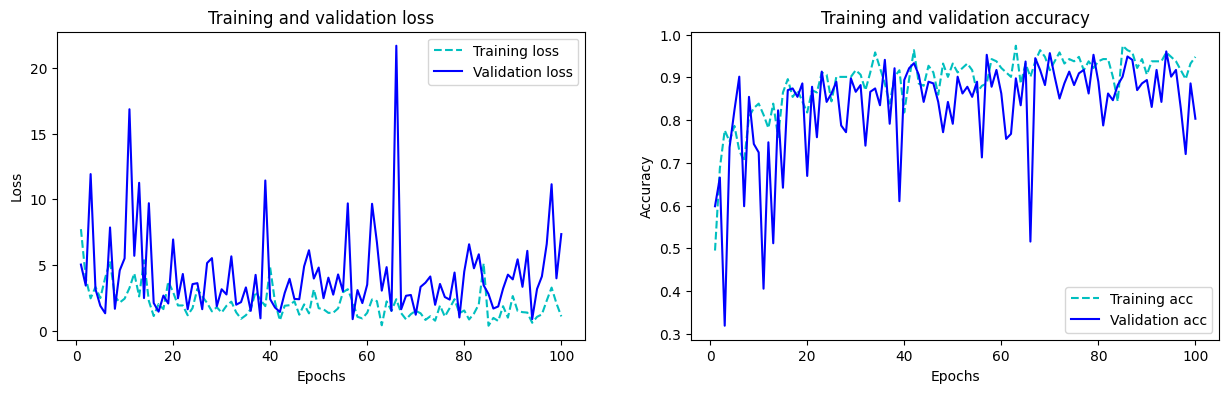

In [54]:
show_result(history_inceptionresnetv2_clahe_model)

In [55]:
inrn2_model_clahe = models.load_model('history_inceptionresnetv2_clahe_model.h5')
#all_test_df_clahe["label"] = all_test_df_clahe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(inrn2_model_clahe, test_set_clahe, all_test_df_clahe['label'])

In [62]:
result_clahe1 = inrn2_model_clahe.evaluate(test_set_clahe, verbose=0)

print("Test loss: {:.5f}".format(result_clahe1[0]))
print("Test accuracy: {:.2f}".format(result_clahe1[1]))

Test loss: 4.26431
Test accuracy: 0.89


### Model Xception

In [30]:
xcep_3 = xcep1_model

In [31]:
#early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5) 
mcp_save = ModelCheckpoint('history_Xception_clahe_model.h5', save_best_only=True, monitor='val_loss')

history_Xception_clahe_model = xcep_3.fit(
                      training_set_clahe,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_clahe),
                      callbacks=[mcp_save]
                      )

Epoch 1/100
48/48 [==============================] - 175s 3s/step - loss: 1.1558 - acc: 0.5312 - val_loss: 0.7147 - val_acc: 0.7244
Epoch 2/100
48/48 [==============================] - 147s 3s/step - loss: 0.6830 - acc: 0.7031 - val_loss: 0.5619 - val_acc: 0.7520
Epoch 3/100
48/48 [==============================] - 160s 3s/step - loss: 0.6723 - acc: 0.7500 - val_loss: 0.5382 - val_acc: 0.7874
Epoch 4/100
48/48 [==============================] - 160s 3s/step - loss: 0.5706 - acc: 0.7552 - val_loss: 0.6828 - val_acc: 0.7323
Epoch 5/100
48/48 [==============================] - 131s 3s/step - loss: 0.4936 - acc: 0.8177 - val_loss: 0.8992 - val_acc: 0.6181
Epoch 6/100
48/48 [==============================] - 135s 3s/step - loss: 0.3588 - acc: 0.8750 - val_loss: 0.3836 - val_acc: 0.8465
Epoch 7/100
48/48 [==============================] - 143s 3s/step - loss: 0.3372 - acc: 0.8802 - val_loss: 0.4230 - val_acc: 0.8622
Epoch 8/100
48/48 [==============================] - 145s 3s/step - loss: 0.

Highest validation accuracy in Epoch: 91
Train accuracy: 0.9270833134651184
Validation accuracy: 0.9527559280395508
--------------------------------------------------
Last train Epoch
Train accuracy: 0.953125
Validation accuracy: 0.9448819160461426


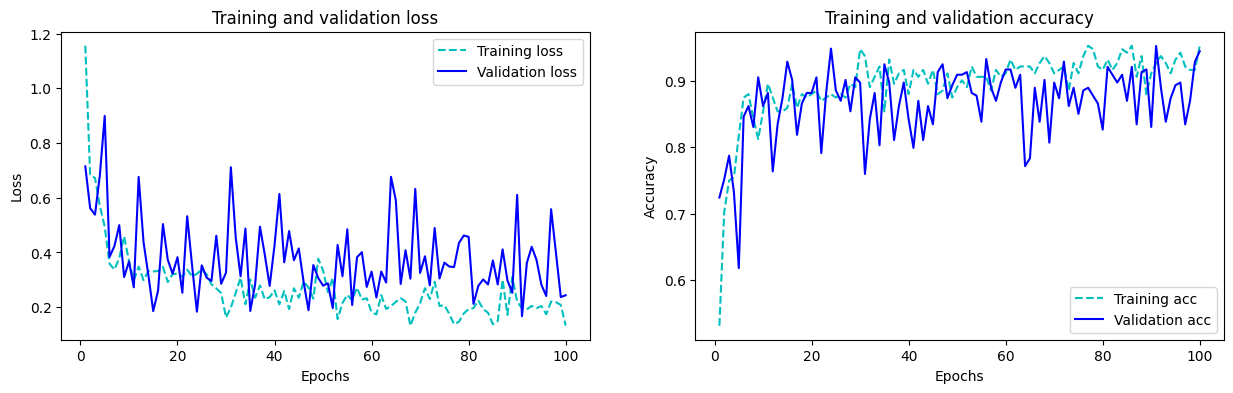

In [32]:
show_result(history_Xception_clahe_model)

In [33]:
xcep_model_clahe = models.load_model('history_Xception_clahe_model.h5')
#all_test_df_clahe["label"] = all_test_df_clahe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(xcep_model_clahe, test_set_clahe, all_test_df_clahe['label'])

In [59]:
result_clahe2 = xcep_model_clahe.evaluate(test_set_clahe, verbose=0)

print("Test loss: {:.5f}".format(result_clahe2[0]))
print("Test accuracy: {:.2f}".format(result_clahe2[1]))

Test loss: 0.43519
Test accuracy: 0.84


### Model efficientnetB 2

In [42]:
effi_6 = effi1_model
effi_6.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 260, 260, 3)  0           ['normalization[0][0]']    

In [36]:
#mcp_save = ModelCheckpoint('history_efficientnet1_1_model_clahe.h5', save_best_only=True, monitor='val_loss')
history_efficientnetB2_clahe_model = effi_6.fit(
                      training_set_clahe,
                      batch_size=4,
                      epochs=100,
                      validation_data = (validation_set_clahe)
                      #callbacks=[mcp_save]
                      )

Epoch 1/100
48/48 [==============================] - 192s 2s/step - loss: 1.0989 - acc: 0.3438 - val_loss: 1.0970 - val_acc: 0.2165
Epoch 2/100
48/48 [==============================] - 76s 2s/step - loss: 1.0994 - acc: 0.3177 - val_loss: 1.0952 - val_acc: 0.2165
Epoch 3/100
48/48 [==============================] - 90s 2s/step - loss: 1.0986 - acc: 0.3490 - val_loss: 1.0982 - val_acc: 0.2165
Epoch 4/100
48/48 [==============================] - 94s 2s/step - loss: 1.0991 - acc: 0.3438 - val_loss: 1.1029 - val_acc: 0.2165
Epoch 5/100
48/48 [==============================] - 93s 2s/step - loss: 1.0986 - acc: 0.3438 - val_loss: 1.1009 - val_acc: 0.2165
Epoch 6/100
48/48 [==============================] - 99s 2s/step - loss: 1.0987 - acc: 0.3438 - val_loss: 1.0999 - val_acc: 0.2165
Epoch 7/100
48/48 [==============================] - 102s 2s/step - loss: 1.0989 - acc: 0.3438 - val_loss: 1.0981 - val_acc: 0.2165
Epoch 8/100
48/48 [==============================] - 102s 2s/step - loss: 1.0987 

In [37]:
#effi_6.save('effi_clahe.h5')

Highest validation accuracy in Epoch: 97
Train accuracy: 0.3645833432674408
Validation accuracy: 0.24015748500823975
--------------------------------------------------
Last train Epoch
Train accuracy: 0.375
Validation accuracy: 0.21653543412685394


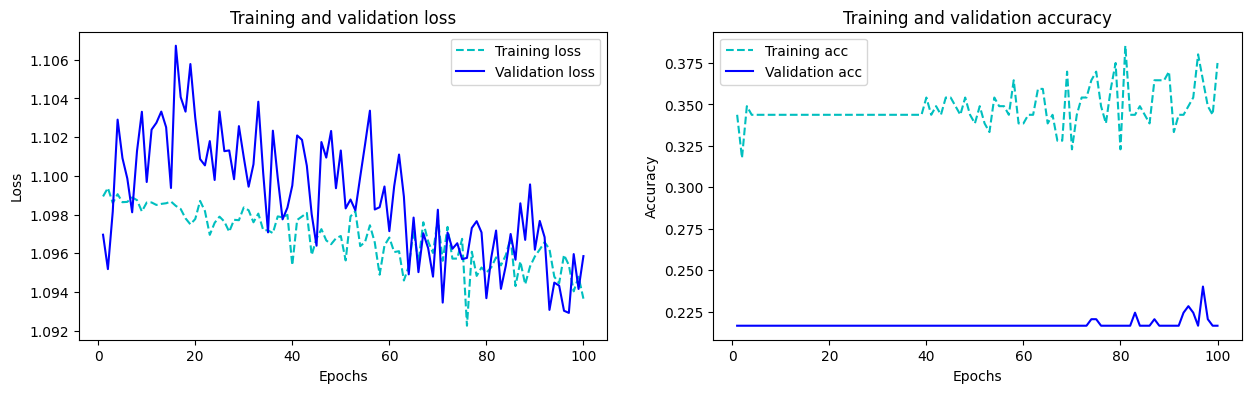

In [38]:
show_result(history_efficientnetB2_clahe_model)

In [39]:
effi_6.save('effi_clahe.h5')
effi_model_clahe = models.load_model('effi_clahe.h5')
result_clahe3 = effi_model_clahe.evaluate(test_set_clahe, verbose=0)

print("Test loss: {:.5f}".format(result_clahe3[0]))
print("Test accuracy: {:.2f}".format(result_clahe3[1]))
#all_test_df_clahe["label"] = all_test_df_clahe["label"].replace({'Cemento' : 2, 'Ossifying' : 1, 'Fibrous' : 0}) 
#evaluation_report(effi_model_clahe, test_set_clahe, all_test_df_clahe['label'])

Test loss: 1.09379
Test accuracy: 0.33


In [44]:
y_pred = effi_model_clahe.predict(test_set_clahe)
y_pred[:2]

12/12 [==============================] - 7s 554ms/step


array([[0.3245533 , 0.34247425, 0.3329725 ],
       [0.32501096, 0.34292242, 0.33206657]], dtype=float32)

In [46]:
predicted_categories = np.argmax(y_pred, axis = 1)
predicted_categories[:2]

#array([1, 0])

array([1, 1], dtype=int64)

In [50]:
#true_categories = tf.concat([y for x, y in test_set_clahe], axis = 0).numpy() # convert to np array

#true_categories[:2]